### Compare fits for pct_high, pct_low, ... etc

In [58]:
from sqlalchemy import create_engine
engine = create_engine('mysql+pymysql://localhost',
                       connect_args={'read_default_file': '~/.mytest.cnf'})
conn = engine.connect()

In [59]:
import pandas as pd
tck_qry = pd.read_sql_query('''select symbol, avg(volume*close) from USE_2021
    group by symbol order by avg(volume*close) desc limit 20''',
                            conn)
tdf = pd.DataFrame(tck_qry, columns=['symbol'])
tickers = tdf['symbol']

In [60]:
def query_symbol(sym, conn):
    qry = pd.read_sql_query(
        '''select tradedate, pct_open, pct_high, pct_low, pct_close,
         pct_hilo, pct_opclo from USEQ_HIST
        where symbol="''' + sym + '''"
        and volume>0
         order by tradedate''',
        conn,
        index_col='tradedate'
    )
    return sym, pd.DataFrame(qry, columns=["pct_open", "pct_high", "pct_low", "pct_close",
                                      "pct_hilo", "pct_opclo"])

In [61]:
import math
def ann_var(var):
    return (math.sqrt((var)*252))

In [62]:
from arch import arch_model
prices = ['pct_open', 'pct_high', 'pct_low', 'pct_close',
          'pct_hilo', 'pct_opclo']

In [63]:
rows = []
tickers=pd.Series(data=['MS']).append(tickers)
tickers=pd.Series(data=['HBP']).append(tickers)

for tk in tickers:
    ticker, df = query_symbol(tk, conn)
    if(len(df.index)<100):
        print("len(df)", len(df.index), "for ticker", tk)
        continue
    for pr in prices:
        am = arch_model(df[pr], p=1, o=1, q=1, dist="StudentsT")
        res = am.fit(disp='off')
        forecasts = res.forecast(reindex=False)
        row = [tk, pr, res.loglikelihood, ann_var(forecasts.variance['h.1'].iloc[0])
               ,res.nobs]
        rows.append(row)

    cmp = pd.DataFrame(rows, columns=['ticker', 'price', 'lhood', 'volatilty', 'nobs'])

compare = cmp.set_index(['ticker', 'price'])
compare.head(36)

lhood  volatilty  nobs
ticker price                                  
HBP    pct_open  -3970.527053  80.441172  1462
       pct_high  -3860.807315  65.280402  1462
       pct_low   -3884.756816  60.488584  1462
       pct_close -3879.824692  62.478496  1462
       pct_hilo  -3870.537144  49.484785  1462
       pct_opclo -3876.604134  63.837785  1462
MS     pct_open  -2886.112817  24.696190  1461
       pct_high  -2726.443082  24.494491  1461
       pct_low   -2833.367142  24.293726  1461
       pct_close -2848.972581  23.925603  1461
       pct_hilo  -2087.129950  13.240142  1461
       pct_opclo -2533.682934  18.461183  1461
SPY    pct_open  -1632.099720   8.759141  1463
       pct_high  -1382.693539   8.102044  1463
       pct_low   -1671.369124   9.540389  1463
       pct_close -1665.757610   8.584599  1463
       pct_hilo  -1160.066051   5.072931  1463
       pct_opclo -1295.711861   8.003001  1463
TSLA   pct_open  -3726.034864  37.050756  1463
       pct_high  -3572.334796  40.272763  1463
       pct_low   -3620.055388  33.616292  1463
       pct_close -3690.751496  33.918250  1463
       pct_hilo  -2995.989529  27.511891  1463
       pct_opclo -3427.280660  27.924684  1463
QQQ    pct_open  -2096.248348  13.437175  1463
       pct_high  -1797.750558  10.464098  1463
       pct_low   -2073.875254  13.239993  1463
       pct_close -2083.022566  14.684301  1463
       pct_hilo  -1553.211570   7.681396  1463
       pct_opclo -1780.907563  12.032578  1463
AAPL   pct_open  -2693.301105  20.447089  1463
       pct_high  -2473.373426  19.476442  1463
       pct_low   -2611.407741  19.416185  1463
       pct_close -2684.002248  18.615249  1463
       pct_hilo  -2002.131797  11.695193  1463
       pct_opclo -2314.050570  16.760452  1463

<AxesSubplot:ylabel='Frequency'>

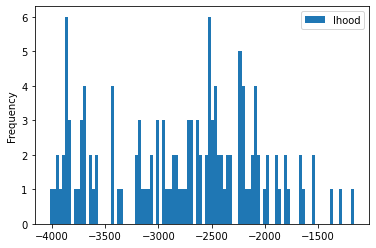

In [64]:
compare[['lhood']].plot(bins=100, kind='hist')

<AxesSubplot:ylabel='Frequency'>

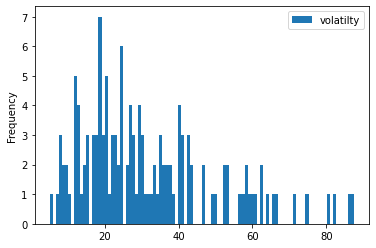

In [65]:
compare[['volatilty']].plot(bins=100, kind='hist')

In [66]:
conn.close()